In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, validation_curve, learning_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, plot_precision_recall_curve, confusion_matrix, classification_report, roc_auc_score

# Telecom Churn

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/telecom_churn.csv')

In [ ]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


* State : 50 штатов и Колумбия

* Account Length : как давно активен аккаунт пользователя 

* Area Code : код зоны 

* Int'l Plan : Активирован ли план с международными звонками 

* VMail Plan : Активирован ли план с голосовыми сообщениями

* VMail Message : Сколько голосовых сообщений отправили

* Day Mins : Сколько минут ушло на дневные звонки

* Day Calls : Сколько раз звонили днем

* Day Charge : Сколько взяли за дневные звонки

* Eve Mins : Сколько минут ушло на вечерние звонки

* Eve Calls : Сколько раз звонили вечером

* Eve Charge : Сколько взяли за вечерние звонки

* Night Mins : Сколько минут ушло на ночные звонки

* Night Calls : Сколько всего ночных звонков

* Night Charge : Сколько взяли за ночные звонки 

* Intl Mins : Сколько минут ушло на звонки за границу

* Intl Calls : Сколько звонков за границу совершил

* Intl Charge : Сколько взяли за международные звонки

* CustServ Calls : Сколько звонил в службу поддержки клиентов 

* Churn : Отток клиентов (таргет: 1 = ушел, 0 = не ушёл)

## Подготовка данных

In [ ]:
#нулевых значений нет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

In [ ]:
#сделаем таргет 0-1 вместо False-True
df['Churn'] = df['Churn'].astype('int')
#тарифные планы тоже
df['International plan'] = df['International plan'].map({'No': 0, 'Yes': 1})
df['Voice mail plan'] = df['Voice mail plan'].map({'No': 0, 'Yes': 1})

In [ ]:
states = df['State']
df.drop(['State'], axis=1, inplace=True)

## EDA

Видим, что в большинстве своём клиенты остаются:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


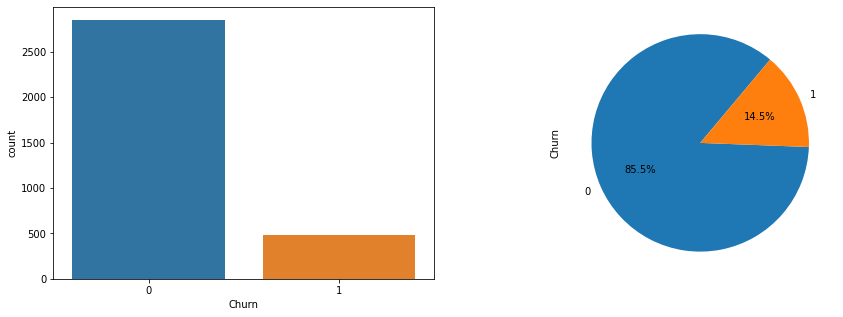

In [ ]:
fig, axs = plt.subplots(1,2, figsize = (15,5))
plt1 = sns.countplot(df['Churn'], ax = axs[0])
plt2 = df['Churn'].value_counts().plot.pie(subplots=True, autopct='%1.1f%%', figsize = (15,5), startangle= 50, ax = axs[1])

Среди тех, кто не подключил голосовую почту / международные звонки горазо больше оставшихся, чем отказавшихся от услуг (невыгодные тарифы?).

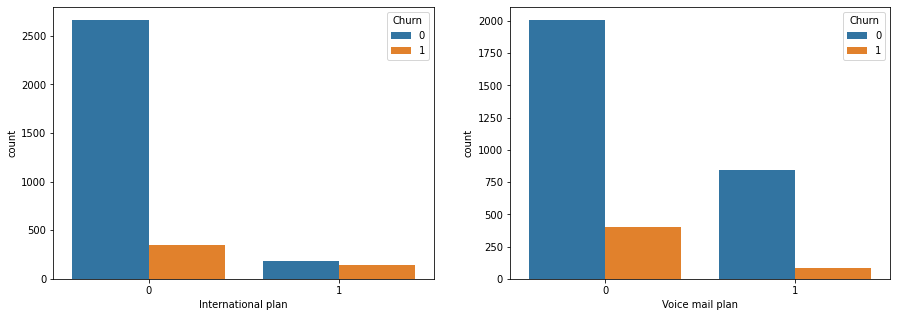

In [ ]:
fig2, axs2 = plt.subplots(1,2, figsize = (15,5))
plt3 = sns.countplot(x='International plan', hue='Churn', data=df, ax = axs2[0])
plt4 = sns.countplot(x='Voice mail plan', hue='Churn', data=df, ax = axs2[1])

Среди тех, кому пришлось 0-2 раза звонить в службу поддержки, больший процент оставшихся клиентов (чем меньше проблем возникает, тем меньше отток?).

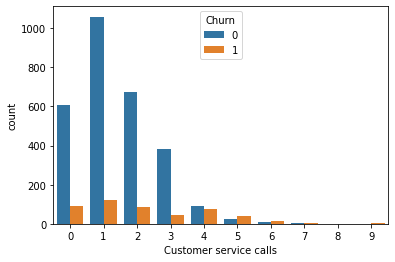

In [ ]:
sns.countplot(x='Customer service calls', hue='Churn', data=df);

Теперь посмотрим на корреляции

In [ ]:
# убираем минус
corrs = abs(df.corr())

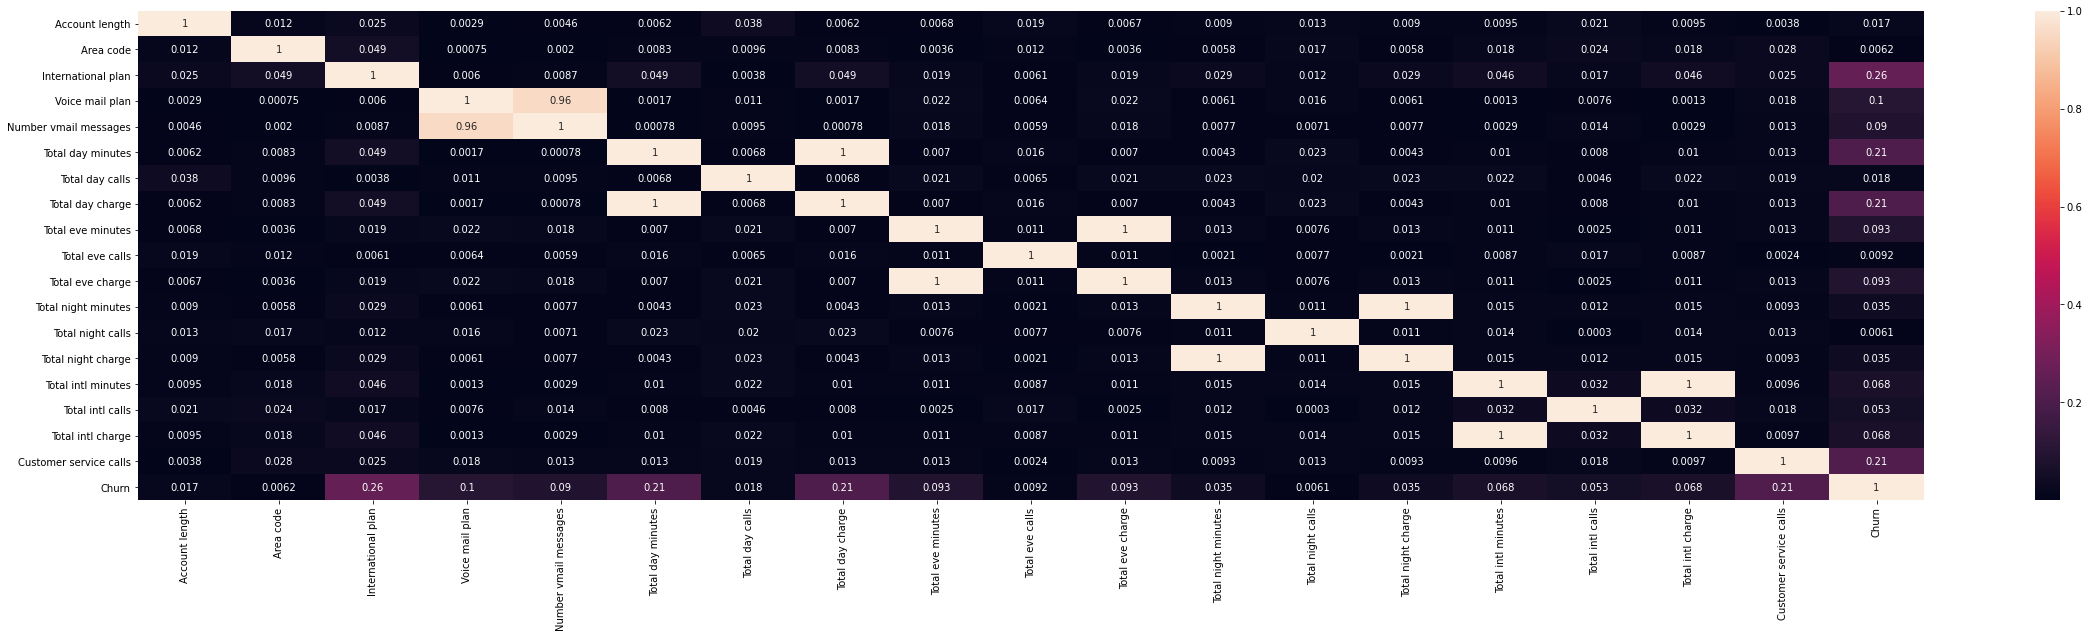

In [ ]:
f, ax = plt.subplots(figsize=(40, 9))
sns.heatmap(corrs, annot=True)

Сколько клиент заплатил всегда коррелирует с количеством минут (ну естественно, что-то из этого нужно дропнуть)

In [ ]:
#дропнем количество минут
df = df.drop(['Number vmail messages', 'Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes'], axis=1)

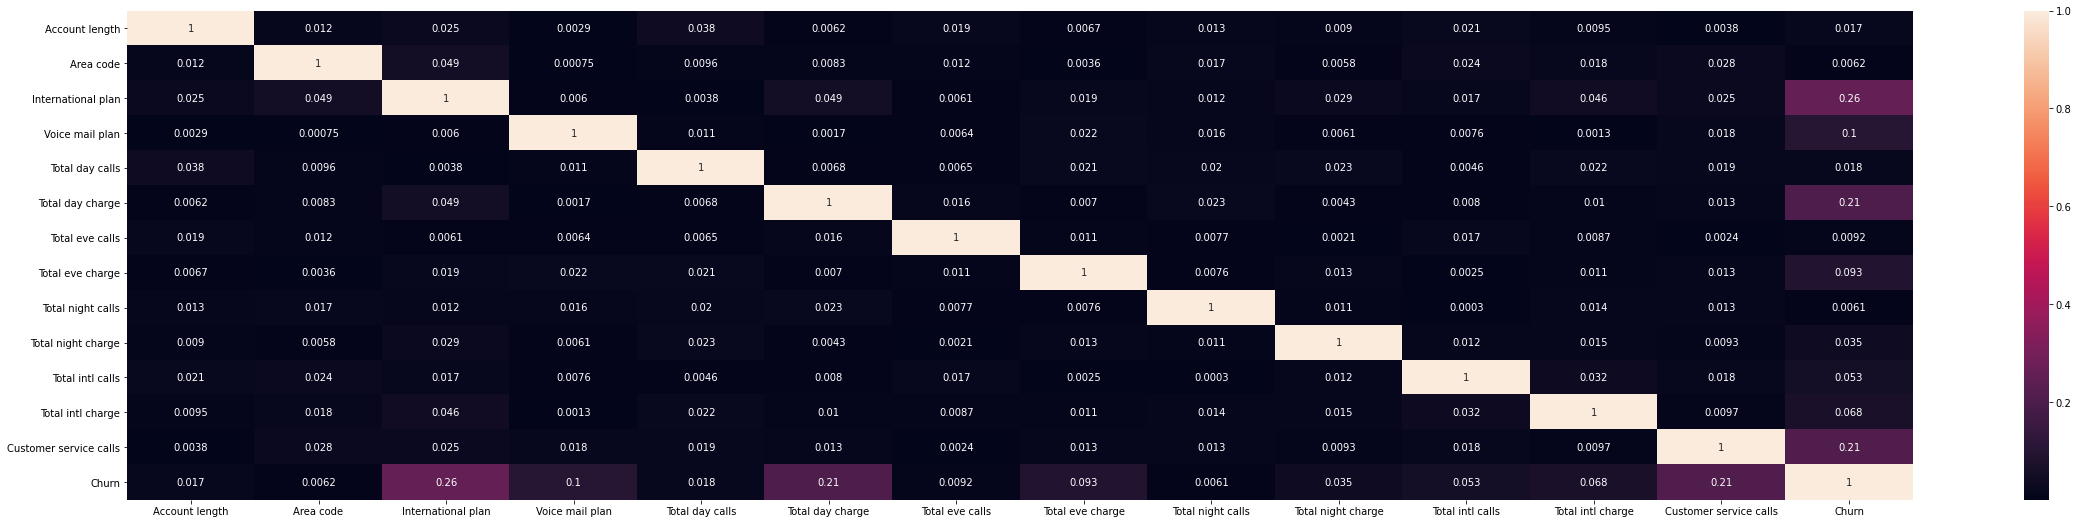

In [ ]:
corrs = abs(df.corr())
f, ax = plt.subplots(figsize=(40, 9))
sns.heatmap(corrs, annot=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


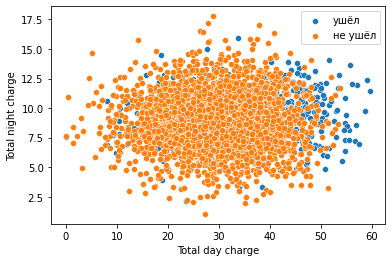

In [ ]:
#распределение таргета
sns.scatterplot(df.loc[df['Churn'] == 1, 'Total day charge'], df.loc[df['Churn'] == 1, 'Total night charge'], label='ушёл')
sns.scatterplot(df.loc[df['Churn'] == 0, 'Total day charge'], df.loc[df['Churn'] == 0, 'Total night charge'], label='не ушёл')
plt.legend();

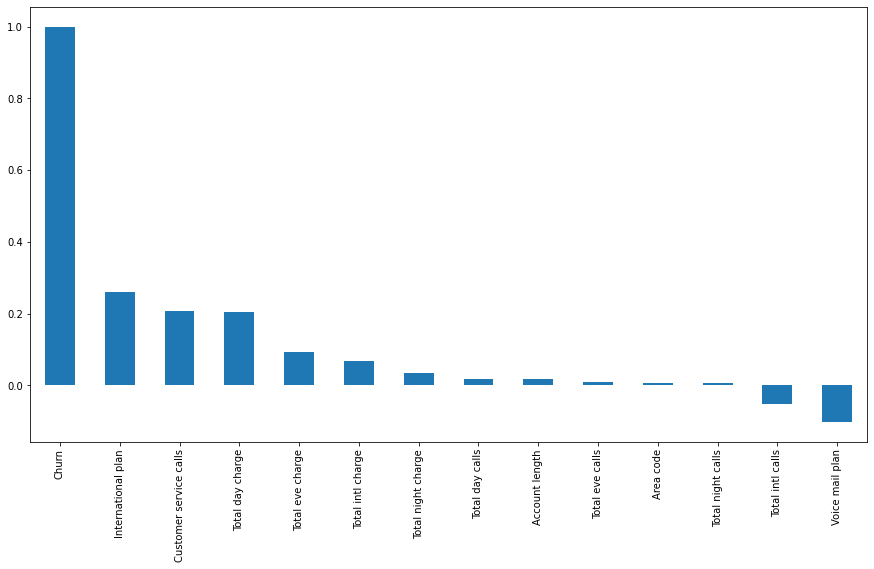

In [ ]:
#Отдельно посмотрим на корреляцию таргета с остальными переменными
plt.figure(figsize=(15,8))
df.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

## Модели

In [ ]:
# Отделяем таргет
X = df.drop(columns ='Churn')
y = pd.Series(df['Churn'])
# Разбиваем на train и test сеты (80% на трейн, 20% на тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print('Тренировочные признаки: ', X_train.shape, 'Тренировочные таргеты: ', y_train.shape, 'Тестовые признаки: ', X_test.shape, 'Тестовые таргеты: ', y_test.shape)

Тренировочные признаки:  (2666, 13) Тренировочные таргеты:  (2666,) Тестовые признаки:  (667, 13) Тестовые таргеты:  (667,)


In [ ]:
#скейлинг
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
rand_for = RandomForestClassifier(max_depth=500)
rand_for.fit(X_train_scaled, y_train)
final_pred = rand_for.predict(X_test_scaled)
rand_for.score(X_test_scaled, y_test)

0.9460269865067467

In [ ]:
roc_auc_score(y_test, final_pred)

0.8099093264248705

###Logistic Regression

In [ ]:
logreg = LogisticRegression()          
logreg = logreg.fit(X_train_scaled, y_train)
final_pred = logreg.predict(X_test_scaled)
roc_auc_score(y_test, final_pred)

0.5927735908305857

### Decision Trees

In [ ]:
Cltree = DecisionTreeClassifier()
Cltree.fit(X_train_scaled, y_train)
final_pred = Cltree.predict(X_test_scaled)
roc_auc_score(y_test, final_pred)


0.8460788682187812

In [ ]:
type(y_train)

pandas.core.series.Series

In [ ]:
X_test.shape

(667, 13)

###KNN

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
final_pred = knn.predict(X_test_scaled)
roc_auc_score(y_test, final_pred)

0.6418718205785154

### SVM

In [ ]:
rbf = svm.SVC(probability=True)
rbf.fit(X_train_scaled, y_train)
final_pred = rbf.predict(X_test_scaled)
roc_auc_score(y_test, final_pred)

0.7243604025101185

### Скоры

In [ ]:
print(f'Скор SVM: {rbf.score(X_train_scaled,y_train)}')
print(f'Скор логистической регрессии: {logreg.score(X_train_scaled,y_train)}')
print(f'Скор KNN: {knn.score(X_train_scaled,y_train)}')
print(f'Скор древесный: {Cltree.score(X_train_scaled,y_train)}')

Скор SVM: 0.9441110277569392
Скор логистической регрессии: 0.8619654913728432
Скор KNN: 0.9144786196549137
Скор древесный: 1.0


## Кроссвалидация

### Модели

Logistic Regression

In [ ]:
logreg_param = {'penalty': ['l2'], 'C': np.logspace(0.01, 1, 5)}
logreg_valid = GridSearchCV(LogisticRegression(), logreg_param, scoring='accuracy', cv=3)
logreg_valid.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 1.02329299,  1.80925591,  3.19889511,  5.65587757, 10.        ]),
                         'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

Decision Trees

In [ ]:
Cltree_param = {'criterion': ['gini', 'entropy'], 'max_depth': [2,4,6,8,10,12]}
Cltree_valid = GridSearchCV(DecisionTreeClassifier(), Cltree_param, scoring='accuracy', cv=3)
Cltree_valid.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

KNN

In [ ]:
knn_param = {'n_neighbors': [3,5,7,9,11,13], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
knn_valid = GridSearchCV(KNeighborsClassifier(), knn_param, scoring='accuracy', cv=3)
knn_valid.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

SVM

In [ ]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', svm.SVC(probability=True))])
rbf_param = {'C': np.logspace(0.01, 1, 5), 'gamma': np.linspace(0.1, 1, num=5), 'kernel': ['rbf']}  

In [ ]:
rbf_valid = GridSearchCV(svm.SVC(probability=True), rbf_param, scoring='accuracy', cv=3)
rbf_valid.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 1.02329299,  1.80925591,  3.19889511,  5.65587757, 10.        ]),
                         'gamma': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

### Результаты

Лучший скор - у SVM и Decision Trees

Logistic Regression

In [ ]:
res_logreg = pd.DataFrame(logreg_valid.cv_results_).loc[:,['params','mean_test_score','std_test_score','rank_test_score']]
print(logreg_valid.best_params_)
print(logreg_valid.best_score_)
res_logreg.sort_values('rank_test_score')

{'C': 3.198895109691398, 'penalty': 'l2'}
0.8570917655563325


,params,mean_test_score,std_test_score,rank_test_score
2,"{'C': 3.198895109691398, 'penalty': 'l2'}",0.857092,0.004789,1
3,"{'C': 5.655877570891539, 'penalty': 'l2'}",0.857092,0.004789,1
4,"{'C': 10.0, 'penalty': 'l2'}",0.857092,0.004789,1
0,"{'C': 1.023292992280754, 'penalty': 'l2'}",0.856717,0.005153,4
1,"{'C': 1.8092559102538208, 'penalty': 'l2'}",0.856717,0.005153,4


Decision Trees

In [ ]:
res_Cltree = pd.DataFrame(Cltree_valid.cv_results_).loc[:,['params','mean_test_score','std_test_score','rank_test_score']]
print(Cltree_valid.best_params_)
print(Cltree_valid.best_score_)
res_Cltree.sort_values('rank_test_score')

{'criterion': 'entropy', 'max_depth': 6}
0.9309866672071396


,params,mean_test_score,std_test_score,rank_test_score
8,"{'criterion': 'entropy', 'max_depth': 6}",0.930987,0.007449,1
9,"{'criterion': 'entropy', 'max_depth': 8}",0.929109,0.005087,2
3,"{'criterion': 'gini', 'max_depth': 8}",0.927608,0.002615,3
2,"{'criterion': 'gini', 'max_depth': 6}",0.927608,0.002929,4
10,"{'criterion': 'entropy', 'max_depth': 10}",0.924985,0.007781,5
4,"{'criterion': 'gini', 'max_depth': 10}",0.922356,0.001571,6
11,"{'criterion': 'entropy', 'max_depth': 12}",0.921230,0.001612,7
5,"{'criterion': 'gini', 'max_depth': 12}",0.914102,0.005078,8
1,"{'criterion': 'gini', 'max_depth': 4}",0.912979,0.001369,9
7,"{'criterion': 'entropy', 'max_depth': 4}",0.912978,0.001945,10


KNN

In [ ]:
res_knn = pd.DataFrame(knn_valid.cv_results_).loc[:,['params','mean_test_score','std_test_score','rank_test_score']]
print(knn_valid.best_params_)
print(knn_valid.best_score_)
res_Cltree.sort_values('rank_test_score')

{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.882595334366988


,params,mean_test_score,std_test_score,rank_test_score
8,"{'criterion': 'entropy', 'max_depth': 6}",0.930987,0.007449,1
9,"{'criterion': 'entropy', 'max_depth': 8}",0.929109,0.005087,2
3,"{'criterion': 'gini', 'max_depth': 8}",0.927608,0.002615,3
2,"{'criterion': 'gini', 'max_depth': 6}",0.927608,0.002929,4
10,"{'criterion': 'entropy', 'max_depth': 10}",0.924985,0.007781,5
4,"{'criterion': 'gini', 'max_depth': 10}",0.922356,0.001571,6
11,"{'criterion': 'entropy', 'max_depth': 12}",0.921230,0.001612,7
5,"{'criterion': 'gini', 'max_depth': 12}",0.914102,0.005078,8
1,"{'criterion': 'gini', 'max_depth': 4}",0.912979,0.001369,9
7,"{'criterion': 'entropy', 'max_depth': 4}",0.912978,0.001945,10


SVM

In [ ]:
res_rbf = pd.DataFrame(rbf_valid.cv_results_).loc[:,['params','mean_test_score','std_test_score','rank_test_score']]
print(rbf_valid.best_params_)
print(rbf_valid.best_score_)
res_rbf.sort_values('rank_test_score')

{'C': 3.198895109691398, 'gamma': 0.1, 'kernel': 'rbf'}
0.9141027979610657


,params,mean_test_score,std_test_score,rank_test_score
10,"{'C': 3.198895109691398, 'gamma': 0.1, 'kernel...",0.914103,0.006126,1
15,"{'C': 5.655877570891539, 'gamma': 0.1, 'kernel...",0.912229,0.005723,2
5,"{'C': 1.8092559102538208, 'gamma': 0.1, 'kerne...",0.910724,0.007959,3
0,"{'C': 1.023292992280754, 'gamma': 0.1, 'kernel...",0.905098,0.006170,4
20,"{'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}",0.903601,0.006447,5
11,"{'C': 3.198895109691398, 'gamma': 0.325, 'kern...",0.874718,0.002858,6
6,"{'C': 1.8092559102538208, 'gamma': 0.325, 'ker...",0.874343,0.002977,7
16,"{'C': 5.655877570891539, 'gamma': 0.325, 'kern...",0.872841,0.003734,8
21,"{'C': 10.0, 'gamma': 0.325, 'kernel': 'rbf'}",0.872467,0.003289,9
1,"{'C': 1.023292992280754, 'gamma': 0.325, 'kern...",0.868342,0.002408,10


## Кривые

Теперь можно ещё построить валидационные кривые, чтобы посмотреть, как некоторые гиперпараметры влияют на точность модели и увидеть есть ли оверфит/андерфит для какого-то гиперпараметра.

In [ ]:
X_scaled = scaler.transform(X)

In [ ]:
def plot_validation(_model, _X, _y, _name, _range, _title):
    _curve = validation_curve(_model, _X, _y, param_name=_name, param_range=_range)
    _test_m = _curve[0].mean(axis=1)
    _test_s = _curve[0].std(axis=1)
    _val_m = _curve[1].mean(axis=1)
    _val_s = _curve[1].std(axis=1)

    plt.plot(_range, _test_m, label='Test')
    plt.fill_between(_range, _test_m - _test_s, _test_m + _test_s, alpha=0.2)
    plt.plot(_range, _val_m, label='Val')
    plt.fill_between(_range, _val_m - _val_s, _val_m + _val_s, alpha=0.2)
    plt.xlabel(_title)
    plt.ylabel('Accuracy')
    plt.legend()

После сближения при С = 1 кривые идут почти параллельно друг другу - усложнять модель посредством С, кажется, нет смысла.

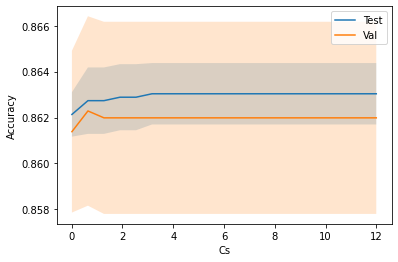

In [ ]:
Cs = np.linspace(0.01, 12, 20)
plot_validation(LogisticRegression(), X_scaled, y, 'C', Cs, 'Cs')

В начале val и train скор низкие, потом с увеличением С оба скора достаточно высоки, но имеется тенденция к переобучению


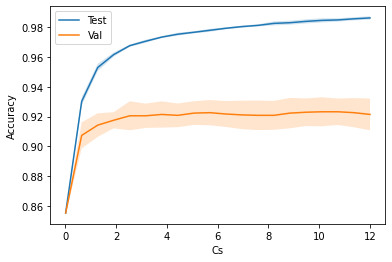

In [ ]:
plot_validation(svm.SVC(), X_scaled, y, 'C', Cs, 'Cs')

Деревья начинают с недообучения на максимальной глубине = 2 и постепенно нормализуется к глубине = 12 

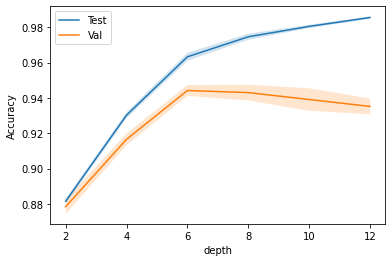

In [ ]:
plot_validation(DecisionTreeClassifier(), X_scaled, y, 'max_depth', [2,4,6,8,10,12], 'Depth')

Вначалале при количестве соседей >4 модель переобучается, дальше кривые постепенно сближаются к n_neighbors > 12. 

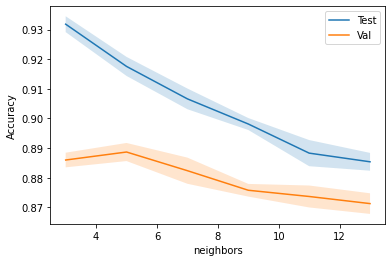

In [ ]:
plot_validation(KNeighborsClassifier(), X_scaled, y, 'n_neighbors', [3,5,7,9,11,13], 'Neighbors')

##Recall, Precision, Accuracy

In [ ]:
rbf_pred = rbf_valid.predict(X_test_scaled)
knn_pred = knn_valid.predict(X_test_scaled)
Cltree_pred = Cltree_valid.predict(X_test_scaled)
logreg_pred = logreg_valid.predict(X_test_scaled)

In [ ]:
def conf_matrix(final_pred):
  confusion = confusion_matrix(y_test, final_pred)
  sns.heatmap(confusion, xticklabels=['Не ушёл', 'Ушёл'], yticklabels=['Не ушёл', 'Ушёл'], annot=True)
  plt.xlabel('final_pred')
  plt.ylabel('y_test')
  plt.show()

In [ ]:
def plot_threshold(_model, _X, _y):
    _prc = precision_recall_curve(_y, np.column_stack(_model.predict_proba(_X))[1])
    plt.plot(_prc[2], _prc[0][:-1], label='Precision')
    plt.plot(_prc[2], _prc[1][:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Precition / Recall')
    plt.legend()

Снова SVM и DecisionTrees выигрывают в accuracy:

**Logistic Regression** - FN. Не очень с предсказаниями единиц (f1-score для ушёл).

              precision    recall  f1-score   support

     Не ушёл       0.89      0.97      0.93       574
        Ушёл       0.57      0.25      0.35        93

    accuracy                           0.87       667
   macro avg       0.73      0.61      0.64       667
weighted avg       0.84      0.87      0.85       667



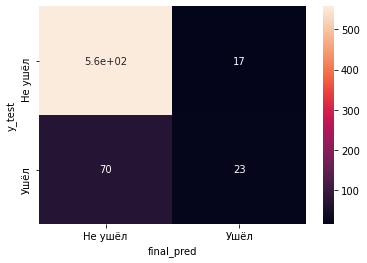

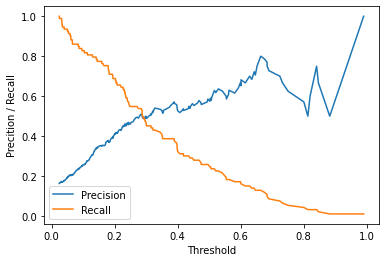

In [ ]:
logreg_rep = classification_report(y_test, logreg_pred, target_names=['Не ушёл', 'Ушёл'])
print(logreg_rep)
conf_matrix(logreg_pred)
plot_threshold(logreg_valid, X_test_scaled, y_test)

**Decision Trees**

              precision    recall  f1-score   support

     Не ушёл       0.96      0.98      0.97       574
        Ушёл       0.88      0.74      0.81        93

    accuracy                           0.95       667
   macro avg       0.92      0.86      0.89       667
weighted avg       0.95      0.95      0.95       667



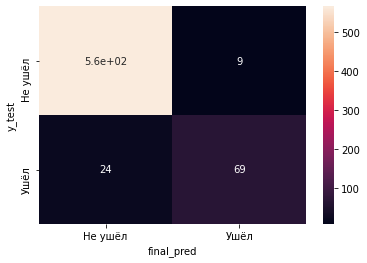

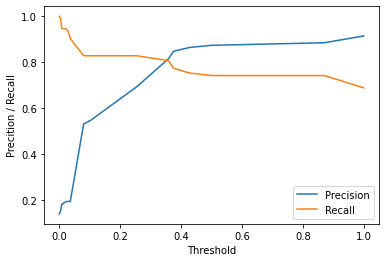

In [ ]:
Cltree_rep = classification_report(y_test, Cltree_pred, target_names=['Не ушёл', 'Ушёл'])
print(Cltree_rep)
conf_matrix(Cltree_pred)
plot_threshold(Cltree_valid, X_test_scaled, y_test)

**KNN** - FN, как и в логистической регрессии, но получше.

              precision    recall  f1-score   support

     Не ушёл       0.91      0.97      0.94       574
        Ушёл       0.72      0.42      0.53        93

    accuracy                           0.90       667
   macro avg       0.82      0.70      0.74       667
weighted avg       0.89      0.90      0.88       667



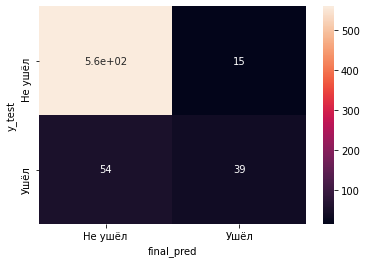

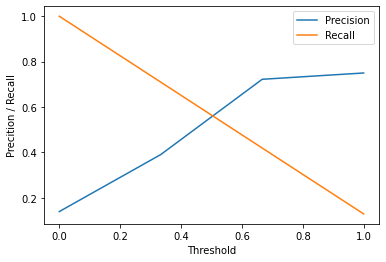

In [ ]:
knn_rep = classification_report(y_test, knn_pred, target_names=['Не ушёл', 'Ушёл'])
print(knn_rep)
conf_matrix(knn_pred)
plot_threshold(knn_valid, X_test_scaled, y_test) #здесь вроде надо отдать knn_valid, это же готовая модель с параметрами, подобранными гридсерчем

**SVM**

              precision    recall  f1-score   support

     Не ушёл       0.94      0.97      0.96       574
        Ушёл       0.79      0.63      0.70        93

    accuracy                           0.93       667
   macro avg       0.86      0.80      0.83       667
weighted avg       0.92      0.93      0.92       667



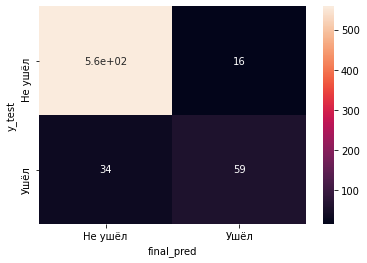

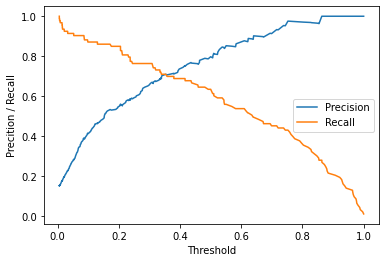

In [ ]:
rbf_rep = classification_report(y_test, rbf_pred, target_names=['Не ушёл', 'Ушёл'])
print(rbf_rep)
conf_matrix(rbf_pred)
plot_threshold(rbf_valid, X_test_scaled, y_test)

## Вывод

Из всех моделей лучше всего подходит SVM и Decision Trees (это стало понятно на этами оценки метрик, поэтому дальнейшая работа шла только с этими моделями). По EDA - всего отписок 14 процентов. Чаще всего отписка происходит при прывышении 4х звонков custom service, при подключении иностранного тарифа и при подключении тарифа на голосовые сообщения. Команда также протестировала работу в едином гит-репозитории (с переменным успехом)